In [8]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [1]:
!nvidia-smi


Tue Apr  2 09:03:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
import cv2
import numpy as np
from typing import List
from matplotlib import pyplot as plt
from IPython.display import display, Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install patool --quiet
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/AI/SK_dataset/melanoma_cancer_dataset.rar", outdir="/content/dataset")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.7 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/AI/SK_dataset/melanoma_cancer_dataset.rar ...
INFO:patool:Extracting /content/drive/MyDrive/AI/SK_dataset/melanoma_cancer_dataset.rar ...
INFO patool: ... creating output directory `/content/dataset'.
INFO:patool:... creating output directory `/content/dataset'.
INFO patool: running /usr/bin/unrar x -- /content/drive/MyDrive/AI/SK_dataset/melanoma_cancer_dataset.rar
INFO:patool:running /usr/bin/unrar x -- /content/drive/MyDrive/AI/SK_dataset/melanoma_cancer_dataset.rar
INFO patool:     with cwd='/content/dataset', input=''
INFO:patool:    with cwd='/content/dataset', input=''
INFO patool: ... /content/drive/MyDrive/AI/SK_dataset/melanoma_cancer_dataset.rar extracted to `/content/dataset'.
INFO:patool:... /content/drive/MyDrive/AI/SK_dataset/melanoma_cancer_dataset.rar extracted to `/content/dataset'.


'/content/dataset'

In [9]:
#prevent exponentially memory growth
physical_devices = tf.config.list_physical_devices("GPU")
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
#!pip install roboflow --quiet

#from roboflow import Roboflow
#rf = Roboflow(api_key="EX21p6P3sYw3SwyBkyQQ")
#project = rf.workspace("martin-rpfil").project("skin-cancer-ihubf")
#version = project.version(1)
#dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths configuration
base_dir = '/content/dataset/melanoma_cancer_dataset'  # Update this to your dataset's path
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')  # Assuming you already have this
validation_dir = os.path.join(base_dir, 'valid')  # Validation directory to create

classes = ['benign', 'malignant']  # Class names

# Create validation directory and class subdirectories
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
    for cls in classes:
        os.mkdir(os.path.join(validation_dir, cls))

# Split ratio configuration
split_ratio = 0.2  # 20% for validation

# Move a subset of images for each class from training to validation
for cls in classes:
    class_dir = os.path.join(train_dir, cls)
    images = os.listdir(class_dir)

    # Split images into training and validation
    train_imgs, valid_imgs = train_test_split(images, test_size=split_ratio, random_state=42)

    # Move validation images to validation directory
    for img in valid_imgs:
        src_path = os.path.join(class_dir, img)
        dest_path = os.path.join(validation_dir, cls, img)
        shutil.move(src_path, dest_path)

print("Data split into training and validation sets.")


Data split into training and validation sets.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories for your dataset
base_dir = '/content/dataset/melanoma_cancer_dataset/'
train_dir = f'{base_dir}/train'
validation_dir = f'{base_dir}/valid'
test_dir = f'{base_dir}/test'

# Initialize the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
    )

test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation/test data

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to fit MobileNetV2 input requirements
    batch_size=64,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary')


Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# The ideal Learning rate, optimizer and layers to unfreeze for fine-tuning

Epoch 1/3
121/121 [==============================] - 145s 911ms/step - loss: 1.0607
Epoch 2/3
121/121 [==============================] - 110s 912ms/step - loss: 0.5640
Epoch 3/3
121/121 [==============================] - 116s 952ms/step - loss: 0.5299


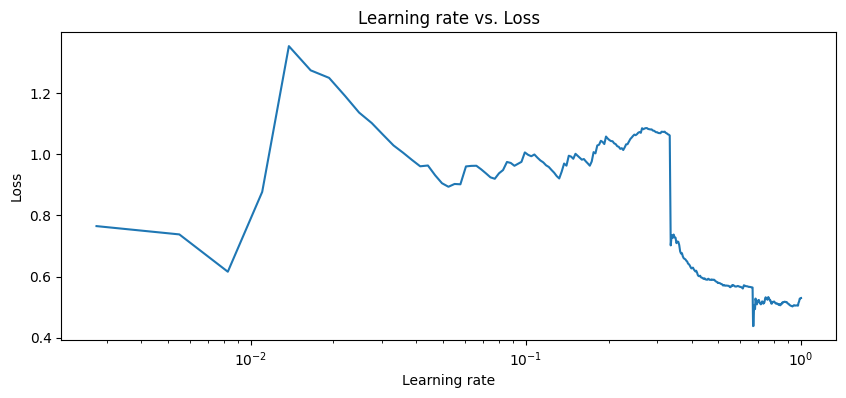

In [10]:
import math
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

class LRFinder(Callback):
    def __init__(self, min_lr=1e-7, max_lr=1, steps_per_epoch=None, epochs=None):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}

    def clr(self):
        """ Calculate the learning rate. """
        x = self.iteration / self.total_iterations
        return self.min_lr + (self.max_lr-self.min_lr) * x

    def on_train_begin(self, logs=None):
        """ Initialize the learning rate to the minimum value at the start of training. """
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, epoch, logs=None):
        """ Update the learning rate and record the current learning rate and loss. """
        logs = logs or {}
        self.iteration += 1

        lr = self.clr()
        self.history.setdefault('lr', []).append(lr)
        self.history.setdefault('loss', []).append(logs.get('loss'))

        tf.keras.backend.set_value(self.model.optimizer.lr, lr)

# Example usage
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(), loss='binary_crossentropy')


lr_finder = LRFinder(min_lr=1e-7, max_lr=1, steps_per_epoch=np.ceil(train_generator.samples/train_generator.batch_size), epochs=3)

model.fit(train_generator, steps_per_epoch=np.ceil(train_generator.samples/train_generator.batch_size), epochs=3, callbacks=[lr_finder])

# Plotting the results
plt.figure(figsize=(10, 4))
plt.plot(lr_finder.history['lr'], lr_finder.history['loss'])
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Learning rate vs. Loss')
plt.show()


# Let's do some testing

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import math
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Define your parameter grid
learning_rates = [1e-2, 5e-2, 1e-1]
optimizers = [Adam, SGD, RMSprop]
fine_tune_layers = [50, 80, 110, 153]  # Starting points for fine-tuning

# Placeholder for recording the results
results = []

for lr in learning_rates:
    for opt_class in optimizers:
        for fine_tune_at in fine_tune_layers:
            print(f"Training with LR: {lr}, Optimizer: {opt_class.__name__}, Fine-tuning at layer: {fine_tune_at}")

            # Reinitialize the model with MobileNetV2 as the base
            base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
            base_model.trainable = False

            model = Sequential([
                base_model,
                GlobalAveragePooling2D(),
                Dropout(0.2),
                Dense(1, activation='sigmoid')
            ])

            optimizer = opt_class(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


                        # Function for step decay schedule
            def step_decay(epoch):
                initial_lr = 0.001  # Starting learning rate
                drop = 0.5  # Reduce learning rate by half
                epochs_drop = 10.0  # Reduce every 10 epochs
                lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
                return lr

            # Define the Early Stopping callback
            early_stopping = EarlyStopping(
                monitor='val_loss',  # Monitor validation loss
                patience=5,  # Number of epochs with no improvement after which training will be stopped
                restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric

            # Set up callbacks
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
            model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
            lr_scheduler = LearningRateScheduler(step_decay)

            # Fit the model
            history = model.fit(
                train_generator,
                steps_per_epoch=train_generator.samples // train_generator.batch_size,
                epochs=30,  # Adjust epochs based on your needs
                validation_data=validation_generator,
                validation_steps=validation_generator.samples // validation_generator.batch_size,
                callbacks=[lr_scheduler, early_stopping, model_checkpoint]
            )

            # Unfreeze the top layers for fine-tuning
            base_model.trainable = True
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False

            # Compile the model for fine-tuning with a lower learning rate
            model.compile(optimizer=opt_class(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

            # Fit the model again (fine-tuning)
            history_fine = model.fit(
                train_generator,
                steps_per_epoch=train_generator.samples // train_generator.batch_size,
                epochs=20,  # Adjust based on your needs
                validation_data=validation_generator,
                validation_steps=validation_generator.samples // validation_generator.batch_size,
                callbacks=[early_stopping, lr_scheduler, model_checkpoint]
            )

            # Get the best validation accuracy from the fine-tuning phase
            best_val_accuracy = max(history_fine.history['val_accuracy'])
            print(f"Best validation accuracy: {best_val_accuracy}")

            # Record the results
            results.append({
                'lr': lr,
                'optimizer': opt_class.__name__,
                'fine_tune_at': fine_tune_at,
                'val_accuracy': best_val_accuracy
            })

# Write results to a file or print them out
with open('model_tuning_results.txt', 'w') as f:
    for result in results:
        f.write(f"LR: {result['lr']}, Optimizer: {result['optimizer']}, Fine-tune Start Layer: {result['fine_tune_at']}, "
                f"Best Val Accuracy: {result['val_accuracy']:.4f}\n")


Training with LR: 0.01, Optimizer: Adam, Fine-tuning at layer: 50
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.7914
Epoch 1: val_accuracy improved from -inf to 0.84167, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 105s 2s/step - loss: 0.4430 - accuracy: 0.7914 - val_loss: 0.3513 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8526
Epoch 2: val_accuracy improved from 0.84167 to 0.85521, saving model to best_model.h5
60/60 [==============================] - 102s 2s/step - loss: 0.3449 - accuracy: 0.8526 - val_loss: 0.3279 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8665
Epoch 3: val_accuracy improved from 0.85521 to 0.86667, saving model to best_model.h5
60/60 [==============================] - 101s 2s/step - loss: 0.3149 - accuracy: 0.8665 - val_loss: 0.3115 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.8673
Epoch 4: val_accuracy improved from 0.86667 to 0.87031, saving model to best_model.h5
60/60 [========================

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.8878
Epoch 1: val_accuracy did not improve from 0.88854
60/60 [==============================] - 118s 2s/step - loss: 0.2938 - accuracy: 0.8878 - val_loss: 6.8432 - val_accuracy: 0.5932 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9252
Epoch 2: val_accuracy did not improve from 0.88854
60/60 [==============================] - 108s 2s/step - loss: 0.1901 - accuracy: 0.9252 - val_loss: 7.0672 - val_accuracy: 0.5792 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - ETA: 0s - loss: 0.1842 - accuracy: 0.9259
Epoch 3: val_accuracy did not improve from 0.88854
60/60 [==============================] - 105s 2s/step - loss: 0.1842 - accuracy: 0.9259 - val_loss: 5.7760 - val_accuracy: 0.6255 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9334
Epoch 4: val_accuracy did not improve from

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.8825
Epoch 1: val_accuracy did not improve from 0.88490
60/60 [==============================] - 121s 2s/step - loss: 0.2959 - accuracy: 0.8825 - val_loss: 13.2750 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.9186
Epoch 2: val_accuracy did not improve from 0.88490
60/60 [==============================] - 105s 2s/step - loss: 0.2030 - accuracy: 0.9186 - val_loss: 5.2218 - val_accuracy: 0.7521 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9206
Epoch 3: val_accuracy did not improve from 0.88490
60/60 [==============================] - 103s 2s/step - loss: 0.2028 - accuracy: 0.9206 - val_loss: 2.5789 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - ETA: 0s - loss: 0.1842 - accuracy: 0.9281
Epoch 4: val_accuracy did not improve fro

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.8650
Epoch 1: val_accuracy did not improve from 0.88594
60/60 [==============================] - 111s 2s/step - loss: 0.3154 - accuracy: 0.8650 - val_loss: 10.0450 - val_accuracy: 0.5255 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.9190
Epoch 2: val_accuracy did not improve from 0.88594
60/60 [==============================] - 101s 2s/step - loss: 0.2079 - accuracy: 0.9190 - val_loss: 9.3306 - val_accuracy: 0.5219 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.9288
Epoch 3: val_accuracy did not improve from 0.88594
60/60 [==============================] - 106s 2s/step - loss: 0.1777 - accuracy: 0.9288 - val_loss: 14.1704 - val_accuracy: 0.5203 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9276
Epoch 4: val_accuracy did not improve fr

#Base Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


# Load MobileNetV2 as the base model, excluding the top (classification) layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification layer
])

model.compile(optimizer=RMSprop(learning_rate=1e-2),  # Start with a learning rate of 0.001
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()  # Optional, to see the model architecture


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
____________________

#Train

In [ ]:
import math
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Model Checkpoint
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Function for step decay schedule
def step_decay(epoch):
    initial_lr = 1e-2  # Starting learning rate
    drop = 0.5  # Reduce learning rate by half
    epochs_drop = 10.0  # Reduce every 10 epochs
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

# Define the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric

# Define the Learning Rate Scheduler callback
lr_scheduler = LearningRateScheduler(step_decay)

# Add both callbacks to the callbacks list in model.fit()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Increased epochs for fine-tuning and allowing the learning rate scheduler to adjust the learning rate
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint])  # Including both callbacks here



Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.7841
Epoch 1: val_accuracy improved from -inf to 0.85677, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 133s 924ms/step - loss: 0.6325 - accuracy: 0.7841 - val_loss: 0.3856 - val_accuracy: 0.8568 - lr: 0.0100
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.8360
Epoch 2: val_accuracy did not improve from 0.85677
120/120 [==============================] - 107s 891ms/step - loss: 0.4718 - accuracy: 0.8360 - val_loss: 0.8220 - val_accuracy: 0.7146 - lr: 0.0100
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.8392
Epoch 3: val_accuracy did not improve from 0.85677
120/120 [==============================] - 105s 872ms/step - loss: 0.4715 - accuracy: 0.8392 - val_loss: 1.0895 - val_accuracy: 0.7437 - lr: 0.0100
Epoch 4/50
120/120 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.8400
Epoch 4: val_accuracy did not improve from 0.85677
120/120 [==============================] - 105s 876ms/step - loss: 0.4920 - accuracy: 0.8400 - val_loss: 0.4540 - v

#Fine-tune

In [ ]:
import math
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc*100:.2f}%')

def fine_tune_model(model, base_model, fine_tune_start_layer=100):
    """
    Unfreeze the top layers of the model and compile the model for fine-tuning.
    """
    base_model.trainable = True

    # Freeze all the layers before the `fine_tune_start_layer`
    for layer in base_model.layers[:fine_tune_start_layer]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),  # Lower learning rate
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Example usage
if test_acc < 0.95:
    fine_tune_at = 154  # Experiment with this value
    model_fine = fine_tune_model(model, base_model, fine_tune_at)

    def step_decay(epoch):
        initial_lr = 1e-2  # Starting learning rate
        drop = 0.5  # Reduce learning rate by half
        epochs_drop = 10.0  # Reduce every 10 epochs
        lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr

    # Define early stopping and learning rate scheduler
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)



    # Model Checkpoint
    model_fine_checkpoint = ModelCheckpoint('fine_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


    history_fine = model_fine.fit(train_generator,
                             steps_per_epoch=train_generator.samples // train_generator.batch_size,
                             epochs=20,  # You might need more epochs
                             validation_data=validation_generator,
                             validation_steps=validation_generator.samples // validation_generator.batch_size,
                             callbacks=[early_stopping, lr_scheduler, model_fine_checkpoint])


15/15 [==============================] - 8s 183ms/step - loss: 0.9091 - accuracy: 0.5042


Test accuracy: 50.42%
Epoch 1/20
120/120 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.7869
Epoch 1: val_accuracy improved from -inf to 0.83281, saving model to fine_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 121s 969ms/step - loss: 0.6203 - accuracy: 0.7869 - val_loss: 0.5273 - val_accuracy: 0.8328 - lr: 0.0100
Epoch 2/20
120/120 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.8287
Epoch 2: val_accuracy did not improve from 0.83281
120/120 [==============================] - 112s 931ms/step - loss: 0.4998 - accuracy: 0.8287 - val_loss: 0.5857 - val_accuracy: 0.7880 - lr: 0.0100
Epoch 3/20
120/120 [==============================] - ETA: 0s - loss: 0.4796 - accuracy: 0.8400
Epoch 3: val_accuracy did not improve from 0.83281
120/120 [==============================] - 113s 939ms/step - loss: 0.4796 - accuracy: 0.8400 - val_loss: 0.6055 - val_accuracy: 0.7922 - lr: 0.0100
Epoch 4/20
120/120 [==============================] - ETA: 0s - loss: 0.4618 - accuracy: 0.8471
Epoch 4: val_accuracy improved from 0.83281 to 0.86771, saving model to fine_best_model.h5
120/120 [==============================] - 112s 938ms/step - loss: 0.4618 -

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_fine.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc*100:.2f}%')

15/15 [==============================] - 3s 162ms/step - loss: 0.2405 - accuracy: 0.9104
Test accuracy: 91.04%


#Save

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model_fine)
tflite_model = converter.convert()

# Save the converted model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
